In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=False)

Mounted at /content/drive


In [2]:
!pip install -q --upgrade --force-reinstall numpy pandas==2.2.2 matplotlib nibabel
!pip uninstall -y torch torchvision torchaudio -qq
!pip install -q torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121
!pip install -q nnunetv2==2.4.2 monai nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, shutil, subprocess, warnings, logging, sys
from pathlib import Path
from tqdm import tqdm
import numpy as np, nibabel as nib, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ---------- 1. 路径与常量 ----------
DRV          = Path("/content/drive/MyDrive/data")                    # 根目录
SRC_DIR      = DRV / "gan_data" / "Synthetic_dataset_random_labels"   # 测试集
OUT_DIR      = DRV / "Baseline_result"; OUT_DIR.mkdir(exist_ok=True)

CSV_NAME     = "metrics_by_region.csv"    # 逐例指标
SUMMARY_CSV  = "summary_stats.csv"        # 全局统计
LOG_NAME     = "inference.log"            # 运行日志
PNG_SUFFIX   = "_overlay.png"             # 可视化文件后缀

DATASET      = "Dataset232_BraTS_2023_rGANs"
TRAINER      = "nnUNetTrainer__nnUNetPlans__3d_fullres"
FOLDS        = ["0", "1", "2", "3", "4"]  # 五折
MODALITY     = "flair"                    # 可视化模态
MOD_MAP      = {"t1ce":"0000","t1":"0001","t2":"0002","flair":"0003"}

# ---------- 2. nnU-Net 环境变量 ----------
os.environ.update({
    "nnUNet_raw":          "/content/nnUNet_raw",
    "nnUNet_preprocessed": "/content/nnUNet_preprocessed",
    "nnUNet_results":      "/content/nnUNet_results",
    "RESULTS_FOLDER":      "/content/nnUNet_results",
})

# ---------- 3. 区域标签定义 ----------
REGIONS = {"wt": [1, 2, 3],   # Whole Tumor
           "tc": [1, 3],      # Tumor Core
           "et": [3]}         # Enhancing Tumor

def dice_iou_binary(p, g):
    tp=(p & g).sum(); fp=(p & ~g).sum(); fn=(~p & g).sum()
    dice = 2*tp / (2*tp + fp + fn + 1e-8)
    iou  = tp   / (tp   + fp + fn + 1e-8)
    return dice, iou

def dice_iou_regions(pred_lbl, gt_lbl):
    m, dices, ious = {}, [], []
    for rk, lbs in REGIONS.items():
        p = np.isin(pred_lbl, lbs)
        g = np.isin(gt_lbl,   lbs)
        d, i = dice_iou_binary(p, g)
        m[f"dice_{rk}"], m[f"iou_{rk}"] = d, i
        dices.append(d); ious.append(i)
    m["dice_mean"], m["iou_mean"] = float(np.mean(dices)), float(np.mean(ious))
    return m

# ---------- 4. 日志 ----------
log_fp = OUT_DIR / LOG_NAME
logger = logging.getLogger("baseline"); logger.setLevel(logging.INFO); logger.handlers.clear()
for h in (logging.StreamHandler(sys.stdout),
          logging.FileHandler(log_fp, encoding="utf-8")):
    h.setFormatter(logging.Formatter("%(asctime)s  %(message)s")); logger.addHandler(h)
logger.info("=== new session ===")

# ---------- 5. CSV（强制重新推理：每次都覆盖） ----------
cols = ["case",
        "dice_mean","dice_wt","dice_tc","dice_et",
        "iou_mean","iou_wt","iou_tc","iou_et"]
csv_fp = OUT_DIR / CSV_NAME
csv_fp.write_text(",".join(cols) + "\n")      # 覆盖写入，从空表开始
done_cases = set()                            # 不跳过任何 case

# ---------- 6. 病例列表 ----------
all_cases  = sorted([d.name for d in SRC_DIR.iterdir() if d.is_dir()])
logger.info(f"total={len(all_cases)}  to_run={len(all_cases)}")

# ---------- 7. 构建 imagesTs ----------
RAW_TS = Path(os.environ["nnUNet_raw"]) / DATASET / "imagesTs"
shutil.rmtree(RAW_TS, ignore_errors=True); RAW_TS.mkdir(parents=True, exist_ok=True)
for c in tqdm(all_cases, desc="link images"):
    for mod, idx in MOD_MAP.items():
        src = SRC_DIR/c/f"{c}-scan_{mod}.nii.gz"
        if src.exists():
            (RAW_TS/f"{c}_{idx}.nii.gz").symlink_to(src.resolve())

# ---------- 8. 拷贝 metadata & checkpoints ----------
PREP = Path(os.environ["nnUNet_preprocessed"]) / DATASET
PREP.mkdir(parents=True, exist_ok=True)
RES  = Path(os.environ["nnUNet_results"]) / DATASET / TRAINER
RES.mkdir(parents=True, exist_ok=True)

for fn in ["dataset.json", "plans.json"]:
    if not (PREP/fn).exists(): shutil.copy(DRV/fn, PREP/fn)
    if not (RES /fn).exists(): shutil.copy(DRV/fn, RES /fn)

for k in FOLDS:
    ck_dst = RES / f"fold_{k}" / "checkpoint_final.pth"
    ck_dst.parent.mkdir(parents=True, exist_ok=True)
    if not ck_dst.exists():
        shutil.copy(DRV / f"fold_{k}" / "checkpoint_final.pth", ck_dst)

# ---------- 9. 推理（实时输出） ----------
PRED_DIR = OUT_DIR / "preds"
shutil.rmtree(PRED_DIR, ignore_errors=True); PRED_DIR.mkdir()
device = "cuda" if Path("/usr/bin/nvidia-smi").exists() else "cpu"
cmd = ["nnUNetv2_predict","--verbose",
       "-i",str(RAW_TS),"-o",str(PRED_DIR),
       "-d",DATASET,"-c","3d_fullres",
       "-f",*FOLDS,"-device",device]

logger.info("nnUNetv2_predict launched…")
with subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                      text=True, bufsize=1, universal_newlines=True) as p:
    for line in p.stdout:
        print(line, end=""); logger.info(line.rstrip())
    p.wait(); assert p.returncode==0, f"predict exited with {p.returncode}"

pred_files = sorted(PRED_DIR.glob("*.nii.gz"))
if not pred_files:
    raise RuntimeError("No prediction files produced!")

# ---------- 10. 逐例评分 ----------
pbar = tqdm(pred_files, desc="score", unit="case")
for pred_fp in pbar:
    case  = pred_fp.stem
    gt_fp = SRC_DIR/case/f"{case}-seg.nii.gz"
    img_fp= SRC_DIR/case/f"{case}-scan_{MODALITY}.nii.gz"
    if not gt_fp.exists():
        logger.warning(f"{case} missing GT, skip"); continue

    pred_lbl = nib.load(pred_fp).get_fdata().astype(np.int16)
    gt_lbl   = nib.load(gt_fp ).get_fdata().astype(np.int16)
    m = dice_iou_regions(pred_lbl, gt_lbl)

    # 进度条尾部
    pbar.set_postfix(mean=f"{m['dice_mean']:.4f}",
                     wt=f"{m['dice_wt']:.3f}",
                     tc=f"{m['dice_tc']:.3f}",
                     et=f"{m['dice_et']:.3f}")
    # 日志
    logger.info(f"{case:<30} "
                f"d_mean={m['dice_mean']:.4f} wt/tc/et={m['dice_wt']:.3f}/{m['dice_tc']:.3f}/{m['dice_et']:.3f}")

    # 写 CSV
    with open(csv_fp, "a") as f:
        f.write(",".join([case]+[f"{m[c]:.6f}" for c in cols[1:]])+"\n")

    # 3-panel quick overlay
    img = nib.load(img_fp).get_fdata(); z = img.shape[2]//2
    img_n = (img[:,:,z]-img[:,:,z].min())/(img[:,:,z].ptp()+1e-8)
    pred_bin = pred_lbl[:,:,z]>0; gt_bin = gt_lbl[:,:,z]>0
    fig,ax=plt.subplots(1,3,figsize=(10,3),dpi=120)
    ax[0].imshow(img_n.T,cmap='gray',origin='lower')
    ax[0].imshow(pred_bin.T,cmap='Reds',alpha=.35,origin='lower'); ax[0].axis('off')
    ax[1].imshow(img_n.T,cmap='gray',origin='lower')
    ax[1].imshow(gt_bin.T,cmap='Greens',alpha=.35,origin='lower'); ax[1].axis('off')
    ov=np.zeros((*pred_bin.T.shape,4))
    ov[(pred_bin.T)&(gt_bin.T)]  =[1,0,0,.4]
    ov[(~pred_bin.T)&(gt_bin.T)] =[0,1,0,.4]
    ov[(pred_bin.T)&(~gt_bin.T)] =[0,0,1,.4]
    ax[2].imshow(img_n.T,cmap='gray',origin='lower')
    ax[2].imshow(ov,origin='lower'); ax[2].axis('off')
    fig.savefig(OUT_DIR/f"{case}{PNG_SUFFIX}",bbox_inches="tight"); plt.close(fig)

# ---------- 11. 全局统计 ----------
df = pd.read_csv(csv_fp)
stats = df.drop(columns="case").describe().T
stats.to_csv(OUT_DIR/SUMMARY_CSV)
logger.info("=== Summary statistics ===\n"+stats.to_string(float_format="%.4f"))

print("\n 全部推理完成！\n• 逐例指标:", csv_fp.name,
      "\n• 汇总统计:", SUMMARY_CSV,
      "\n• 日志文件:", LOG_NAME,
      "\n• 预测 NIfTI 存放目录:", PRED_DIR)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Robust nnU-Net inference (NumPy-2.0 safe)
• resume & skip completed
• per-case WT/TC/ET metrics
• save WT/TC/ET binary masks as NIfTI
• log failed cases
"""

import os, shutil, subprocess, warnings, logging, json
from pathlib import Path
from tqdm import tqdm
import numpy as np, nibabel as nib, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ---------- 1. paths ----------
DRV      = Path("/content/drive/MyDrive/data")
SRC_DIR  = DRV / "gan_data" / "Synthetic_dataset_random_labels"
OUT_DIR  = DRV / "Baseline_result"; OUT_DIR.mkdir(exist_ok=True)

CSV_NAME, SUMMARY_CSV = "metrics_by_region.csv", "summary_stats.csv"
FAILED_JSON, LOG_NAME = "failed_cases.json", "inference.log"
PNG_SUFFIX  = "_overlay.png"

DATASET  = "Dataset232_BraTS_2023_rGANs"
TRAINER  = "nnUNetTrainer__nnUNetPlans__3d_fullres"
FOLDS    = ["0","1","2","3","4"]
MOD_MAP  = {"t1ce":"0000","t1":"0001","t2":"0002","flair":"0003"}
MODALITY = "flair"

# ---------- 2. env ----------
os.environ.update({
    "nnUNet_raw":          "/content/nnUNet_raw",
    "nnUNet_preprocessed": "/content/nnUNet_preprocessed",
    "nnUNet_results":      "/content/nnUNet_results",
    "RESULTS_FOLDER":      "/content/nnUNet_results",
})

# ---------- 3. logger ----------
logger = logging.getLogger("baseline"); logger.setLevel(logging.INFO); logger.handlers.clear()
for h in (logging.StreamHandler(),
          logging.FileHandler(OUT_DIR/LOG_NAME, encoding="utf-8")):
    h.setFormatter(logging.Formatter("%(asctime)s  %(message)s")); logger.addHandler(h)
logger.info("=== new session ===")

# ---------- 4. metric helpers ----------
REGIONS = {"wt":[1,2,3], "tc":[1,3], "et":[3]}
def dice_iou_binary(p,g):
    tp=(p&g).sum(); fp=(p&~g).sum(); fn=(~p&g).sum()
    return 2*tp/(2*tp+fp+fn+1e-8), tp/(tp+fp+fn+1e-8)
def dice_iou_regions(pred,gt):
    m,ds,ios={},[],[]
    for k,lbs in REGIONS.items():
        d,i=dice_iou_binary(np.isin(pred,lbs),np.isin(gt,lbs))
        m[f"dice_{k}"],m[f"iou_{k}"]=d,i; ds.append(d); ios.append(i)
    m["dice_mean"],m["iou_mean"]=float(np.mean(ds)),float(np.mean(ios)); return m
def normalize_slice(arr2d):
    """min-max 到 [0,1]，NumPy-2.0 safe"""
    return (arr2d-arr2d.min())/(np.ptp(arr2d)+1e-8)

# ---------- 5. csv & done ----------
cols=["case","dice_mean","dice_wt","dice_tc","dice_et",
      "iou_mean","iou_wt","iou_tc","iou_et"]
csv_fp=OUT_DIR/CSV_NAME
done_cases=set(pd.read_csv(csv_fp)["case"]) if csv_fp.exists() else set()
if not csv_fp.exists(): csv_fp.write_text(",".join(cols)+"\n")

failed=json.loads((OUT_DIR/FAILED_JSON).read_text()) if (OUT_DIR/FAILED_JSON).exists() else []

# ---------- 6. case lists ----------
all_cases=sorted(d.name for d in SRC_DIR.iterdir() if d.is_dir())
PRED_DIR=OUT_DIR/"preds"; PRED_DIR.mkdir(exist_ok=True)
to_score,to_infer=[],[]
for c in all_cases:
    if c in done_cases: continue
    if (PRED_DIR/f"{c}.nii.gz").exists(): to_score.append(c); continue
    if all((SRC_DIR/c/f"{c}-scan_{m}.nii.gz").exists() for m in MOD_MAP):
        to_infer.append(c)
    else:
        failed.append(c); logger.warning(f"{c} 缺失模态，跳过")
logger.info(f"Need inference {len(to_infer)} | Need scoring {len(to_score)}")

# ---------- 7. prepare nnU-Net ----------
for root in ("nnUNet_preprocessed","nnUNet_results"):
    (Path(os.environ[root])/DATASET).mkdir(parents=True, exist_ok=True)
for fn in ("dataset.json","plans.json"):
    for root in ("nnUNet_preprocessed","nnUNet_results"):
        dst=Path(os.environ[root])/DATASET/fn
        if not dst.exists(): shutil.copy(DRV/fn, dst)
for k in FOLDS:
    ck=Path(os.environ["nnUNet_results"])/DATASET/TRAINER/f"fold_{k}/checkpoint_final.pth"
    ck.parent.mkdir(parents=True, exist_ok=True)
    if not ck.exists(): shutil.copy(DRV/f"fold_{k}"/"checkpoint_final.pth", ck)

device="cuda" if Path("/usr/bin/nvidia-smi").exists() else "cpu"
RAW_ROOT=Path(os.environ["nnUNet_raw"])/DATASET; RAW_ROOT.mkdir(parents=True, exist_ok=True)

# ---------- 8. inference ----------
for case in tqdm(to_infer, desc="infer"):
    RAW_TS=RAW_ROOT/"imagesTs"; shutil.rmtree(RAW_TS, ignore_errors=True); RAW_TS.mkdir()
    for m,idx in MOD_MAP.items():
        (RAW_TS/f"{case}_{idx}.nii.gz").symlink_to((SRC_DIR/case/f"{case}-scan_{m}.nii.gz").resolve())
    cmd=["nnUNetv2_predict","--verbose","-i",str(RAW_TS),"-o",str(PRED_DIR),
         "-d",DATASET,"-c","3d_fullres","-f",*FOLDS,"-device",device]
    try:
        subprocess.run(cmd, check=True)
        to_score.append(case)
    except subprocess.CalledProcessError as e:
        logger.error(f"{case} inference failed"); failed.append(case)

# ---------- 9. scoring ----------
REGION_DIR=OUT_DIR/"preds_regions"; REGION_DIR.mkdir(exist_ok=True)
def flush(row):
    with open(csv_fp,"a") as f: f.write(row+"\n"); f.flush(); os.fsync(f.fileno())

for c in tqdm(sorted(set(to_score)), desc="score"):
    if c in done_cases: continue
    pred_fp, gt_fp = PRED_DIR/f"{c}.nii.gz", SRC_DIR/c/f"{c}-seg.nii.gz"
    if not (pred_fp.exists() and gt_fp.exists()):
        failed.append(c); continue
    pred=nib.load(pred_fp).get_fdata().astype(np.int16)
    gt  =nib.load(gt_fp ).get_fdata().astype(np.int16)
    m=dice_iou_regions(pred,gt)
    logger.info(f"{c:<28} mean={m['dice_mean']:.4f} wt/tc/et="
                f"{m['dice_wt']:.3f}/{m['dice_tc']:.3f}/{m['dice_et']:.3f}")
    flush(",".join([c]+[f"{m[k]:.6f}" for k in cols[1:]]))

    affine=nib.load(pred_fp).affine
    for rk,lbs in REGIONS.items():
        mask=np.isin(pred,lbs).astype(np.uint8)
        nib.save(nib.Nifti1Image(mask,affine), REGION_DIR/f"{c}_{rk}.nii.gz")

    img_fp=SRC_DIR/c/f"{c}-scan_{MODALITY}.nii.gz"
    if img_fp.exists():
        img=nib.load(img_fp).get_fdata(); z=img.shape[2]//2
        img_n=normalize_slice(img[:,:,z])
        pb,gb=pred[:,:,z]>0, gt[:,:,z]>0
        fig,ax=plt.subplots(1,3,figsize=(9,3),dpi=120)
        ax[0].imshow(img_n.T,cmap='gray',origin='lower'); ax[0].imshow(pb.T,cmap='Reds',alpha=.35,origin='lower'); ax[0].axis('off')
        ax[1].imshow(img_n.T,cmap='gray',origin='lower'); ax[1].imshow(gb.T,cmap='Greens',alpha=.35,origin='lower'); ax[1].axis('off')
        ov=np.zeros((*pb.T.shape,4)); ov[(pb.T)&(gb.T)]=[1,0,0,.4]
        ov[(~pb.T)&(gb.T)]=[0,1,0,.4]; ov[(pb.T)&(~gb.T)]=[0,0,1,.4]
        ax[2].imshow(img_n.T,cmap='gray',origin='lower'); ax[2].imshow(ov,origin='lower'); ax[2].axis('off')
        fig.savefig(OUT_DIR/f"{c}{PNG_SUFFIX}",bbox_inches="tight"); plt.close(fig)

# ---------- 10. summary & failed ----------
(OUT_DIR/FAILED_JSON).write_text(json.dumps(sorted(set(failed)), indent=1))
df=pd.read_csv(csv_fp)
if not df.empty:
    df.drop(columns="case").describe().T.to_csv(OUT_DIR/SUMMARY_CSV)
    logger.info("summary updated")

print("\n 完成:", len(df),
      "\n 失败:", len(failed),
      "\n CSV:", CSV_NAME,
      "\n masks:", REGION_DIR,
      "\n preds:", PRED_DIR)

2025-07-29 23:29:06,367  === new session ===
INFO:baseline:=== new session ===
2025-07-29 23:29:06,458  BraTS-GLI-00824-000_fake_label_66 缺失模态，跳过
2025-07-29 23:29:06,464  Need inference 0 | Need scoring 293
INFO:baseline:Need inference 0 | Need scoring 293
infer: 0it [00:00, ?it/s]
score:   0%|          | 0/293 [00:00<?, ?it/s]2025-07-29 23:29:07,479  BraTS-GLI-00819-000_real_label_48 mean=0.7289 wt/tc/et=0.886/0.362/0.939
INFO:baseline:BraTS-GLI-00819-000_real_label_48 mean=0.7289 wt/tc/et=0.886/0.362/0.939
score:   0%|          | 1/293 [00:02<11:06,  2.28s/it]2025-07-29 23:29:09,634  BraTS-GLI-00819-000_real_label_51 mean=0.7418 wt/tc/et=0.899/0.386/0.940
INFO:baseline:BraTS-GLI-00819-000_real_label_51 mean=0.7418 wt/tc/et=0.899/0.386/0.940
score:   1%|          | 2/293 [00:04<10:15,  2.11s/it]2025-07-29 23:29:12,266  BraTS-GLI-00819-000_real_label_52 mean=0.7004 wt/tc/et=0.907/0.271/0.923
INFO:baseline:BraTS-GLI-00819-000_real_label_52 mean=0.7004 wt/tc/et=0.907/0.271/0.923
score:  


 完成: 295 
 失败: 1 
 CSV: metrics_by_region.csv 
 masks: /content/drive/MyDrive/data/Baseline_result/preds_regions 
 preds: /content/drive/MyDrive/data/Baseline_result/preds


Loaded 295 cases from /content/drive/MyDrive/data/Baseline_result/metrics_by_region.csv


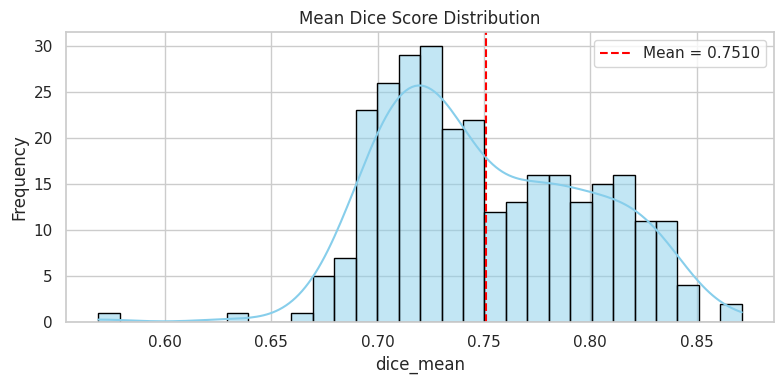

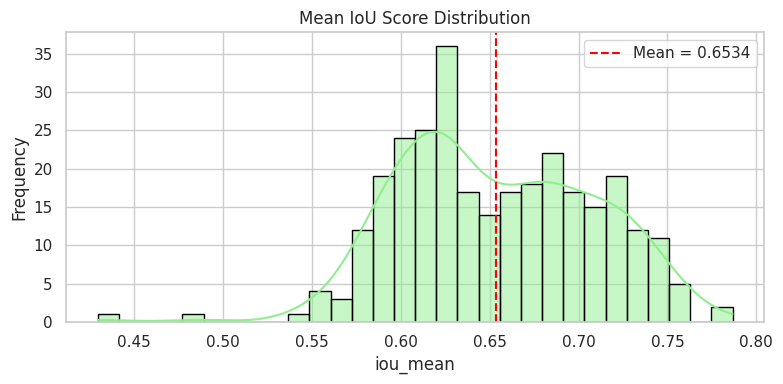

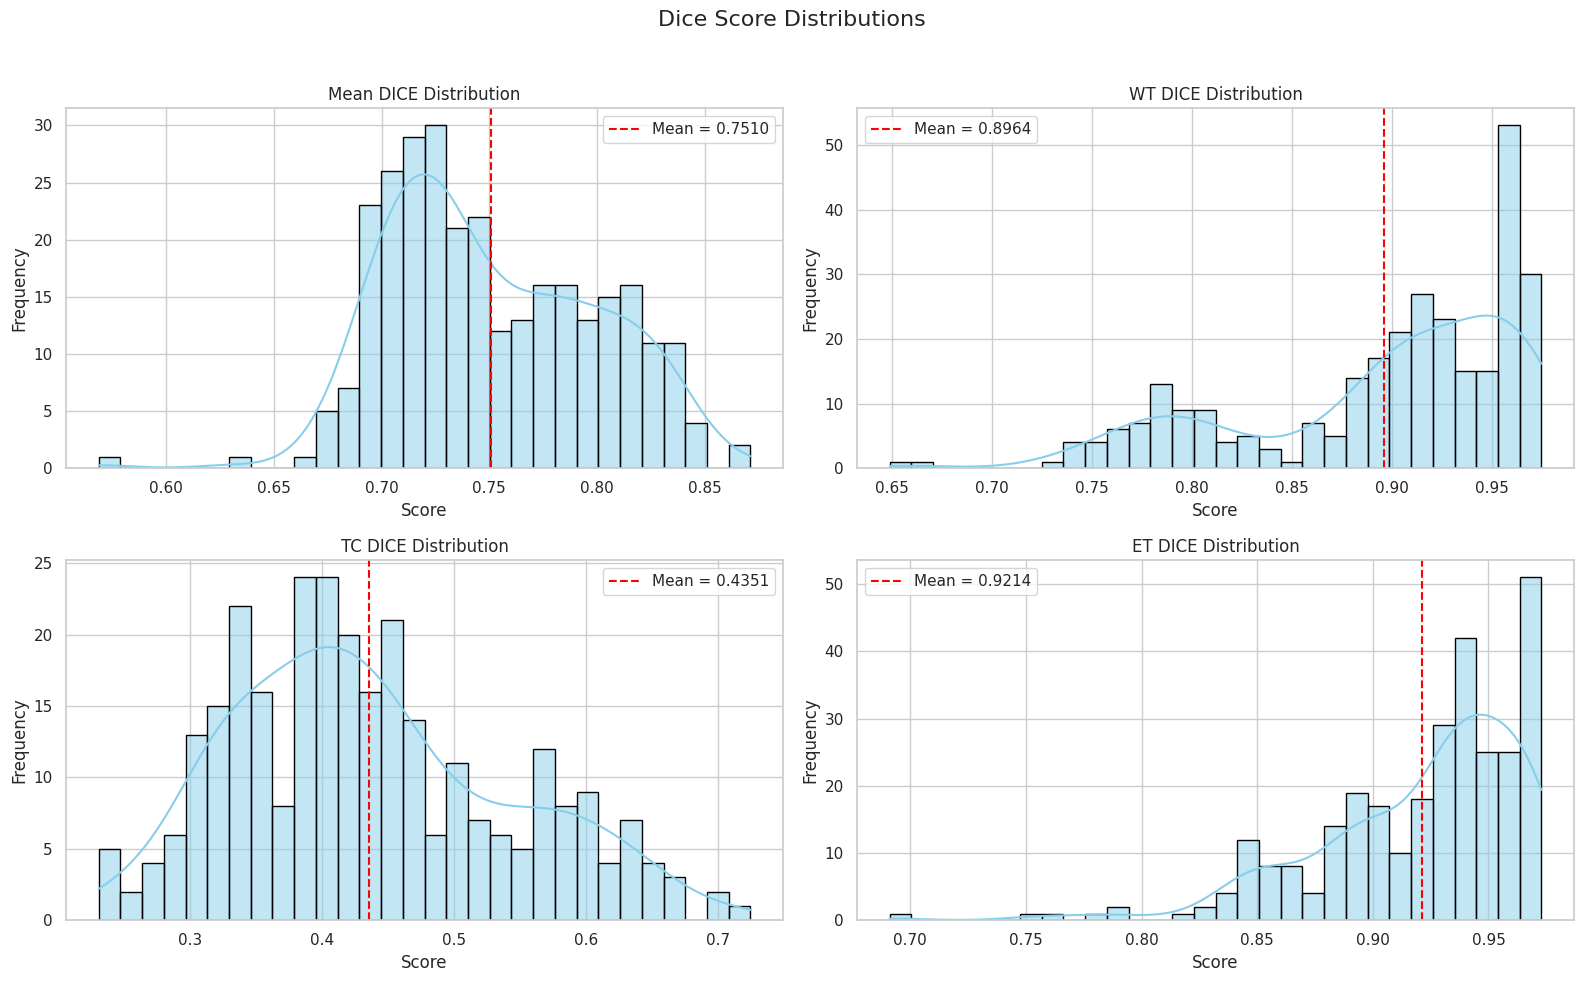

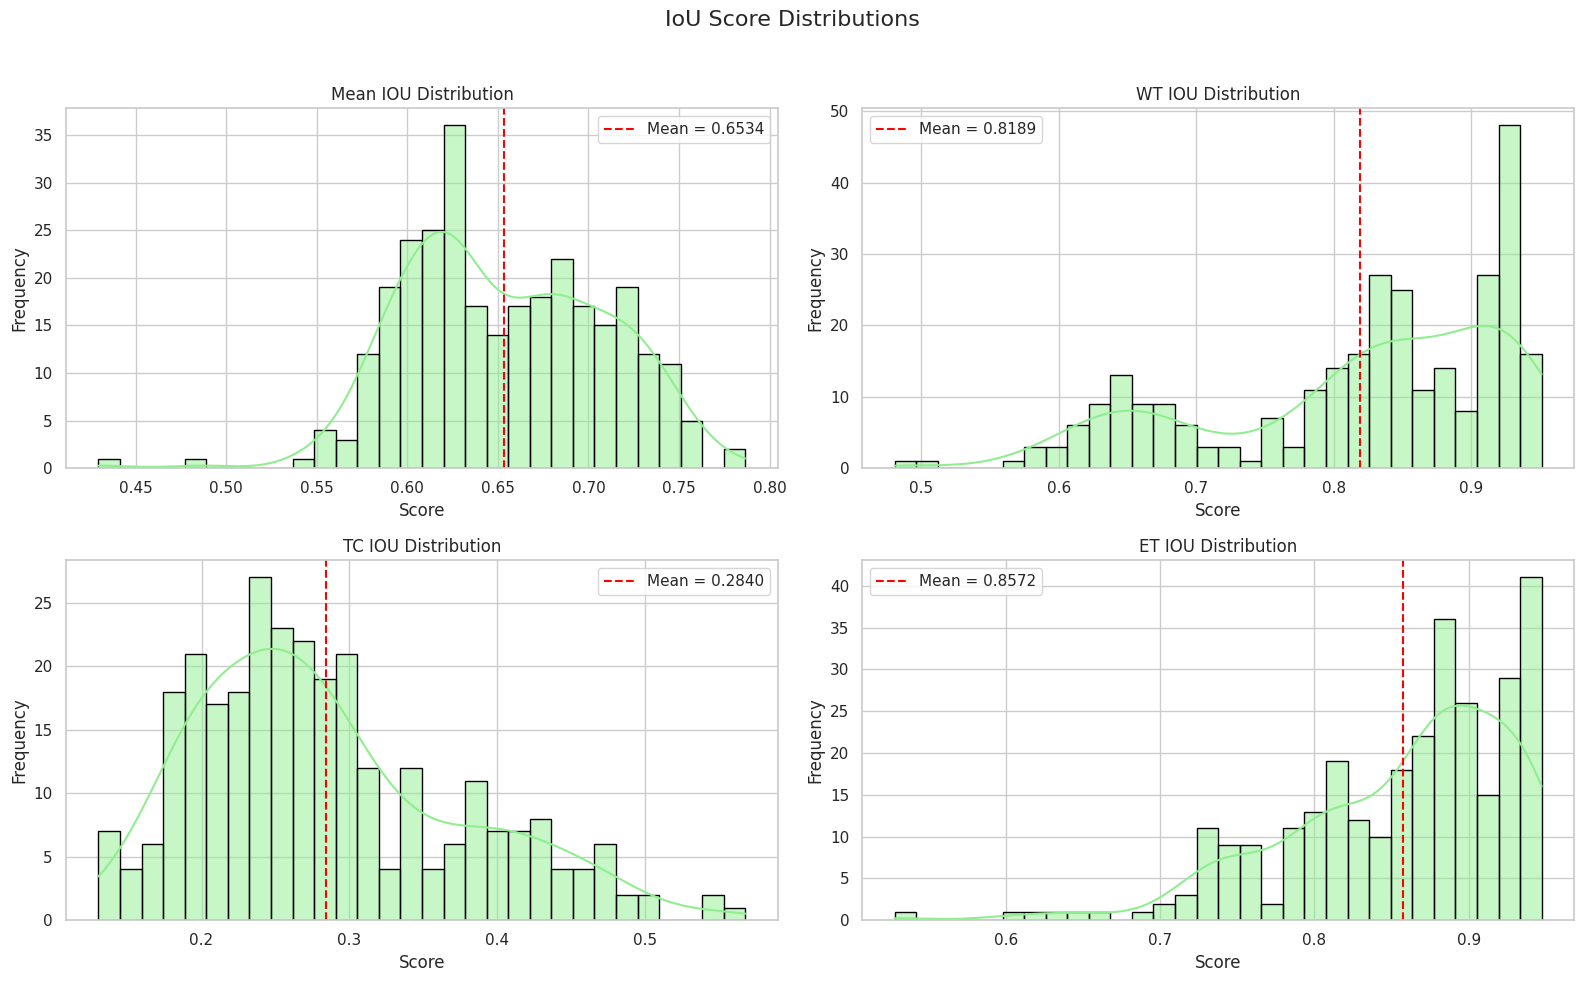


--- Percentiles (25 / 50 / 75 / 90 / 95) ---

dice_mean:
0.25    0.7136
0.50    0.7425
0.75    0.7879
0.90    0.8200
0.95    0.8338
Name: dice_mean, dtype: float64

iou_mean:
0.25    0.6136
0.50    0.6491
0.75    0.6962
0.90    0.7274
0.95    0.7407
Name: iou_mean, dtype: float64


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Show histograms for nnU-Net metrics (no file saving)
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- 1. 路径 ----------
CSV_PATH = "/content/drive/MyDrive/data/Baseline_result/metrics_by_region.csv"

# ---------- 2. 读取 ----------
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} cases from {CSV_PATH}")

# ---------- 3. 绘图风格 ----------
sns.set(style="whitegrid")

# ---------- 4. 单变量直方图 ----------
def show_single(col, title, color):
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30, color=color, edgecolor="black")
    mean_val = df[col].mean()
    plt.axvline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.4f}")
    plt.title(title); plt.xlabel(col); plt.ylabel("Frequency"); plt.legend()
    plt.tight_layout(); plt.show()

show_single("dice_mean", "Mean Dice Score Distribution", "skyblue")
show_single("iou_mean",  "Mean IoU Score Distribution",  "lightgreen")

# ---------- 5. 2×2 网格 ----------
def show_grid(prefix, color, suptitle):
    metrics = {f"{prefix}_mean": f"Mean {prefix.upper()}",
               f"{prefix}_wt":   f"WT {prefix.upper()}",
               f"{prefix}_tc":   f"TC {prefix.upper()}",
               f"{prefix}_et":   f"ET {prefix.upper()}"}
    fig, axes = plt.subplots(2,2, figsize=(16,10)); axes = axes.ravel()
    for i,(col,title) in enumerate(metrics.items()):
        ax = axes[i]
        sns.histplot(df[col], kde=True, bins=30, color=color, edgecolor="black", ax=ax)
        mean_val = df[col].mean()
        ax.axvline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.4f}")
        ax.set_title(f"{title} Distribution"); ax.set_xlabel("Score"); ax.set_ylabel("Frequency"); ax.legend()
    fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

show_grid("dice", "skyblue",   "Dice Score Distributions")
show_grid("iou",  "lightgreen","IoU Score Distributions")

# ---------- 6. 打印百分位数 ----------
print("\n--- Percentiles (25 / 50 / 75 / 90 / 95) ---")
for col in ("dice_mean","iou_mean"):
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].quantile([.25,.5,.75,.9,.95]).round(4))

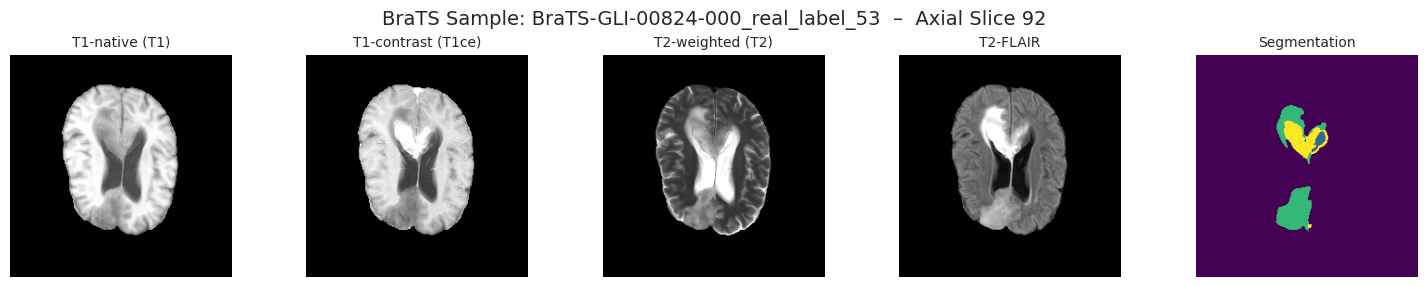

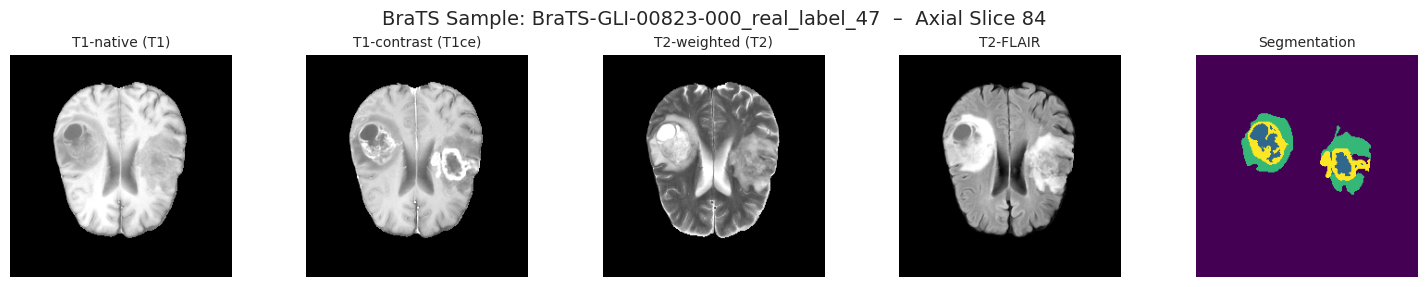

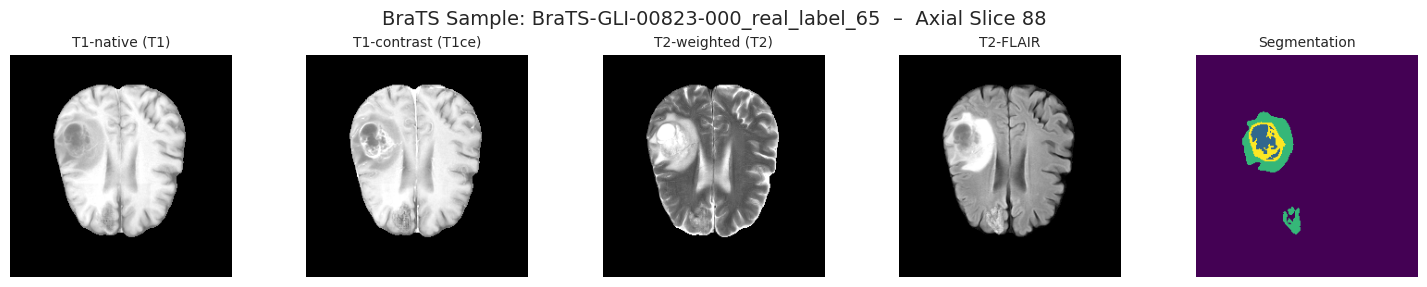

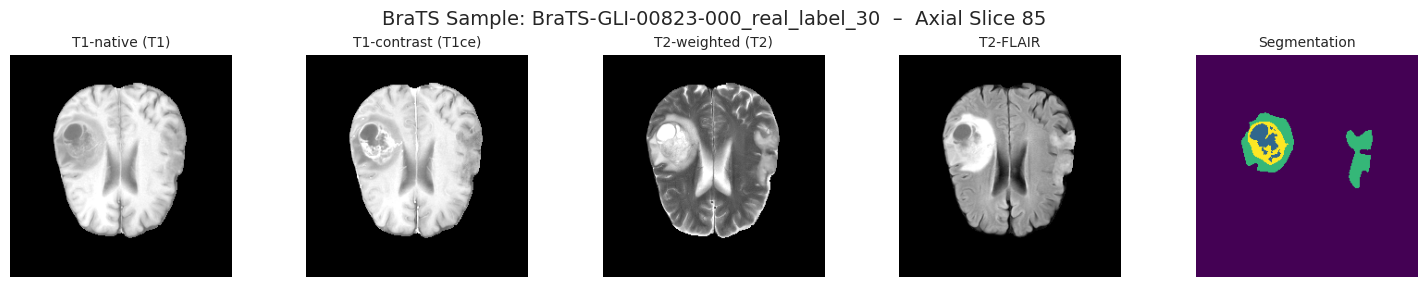

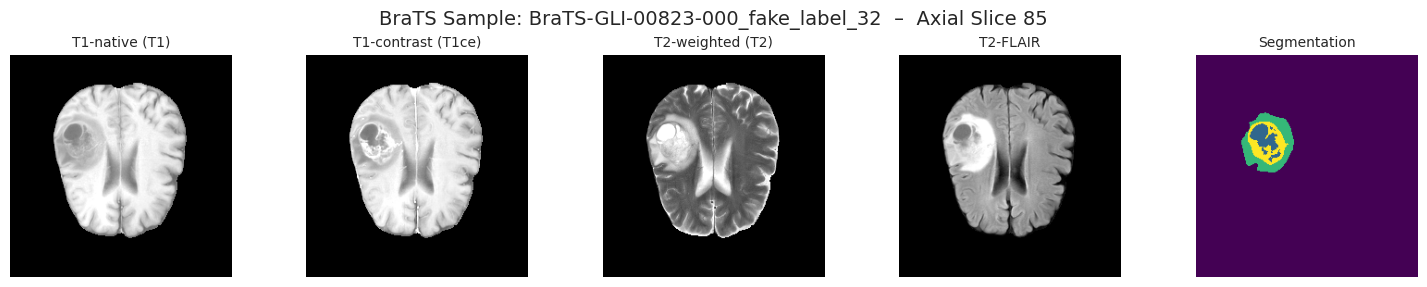

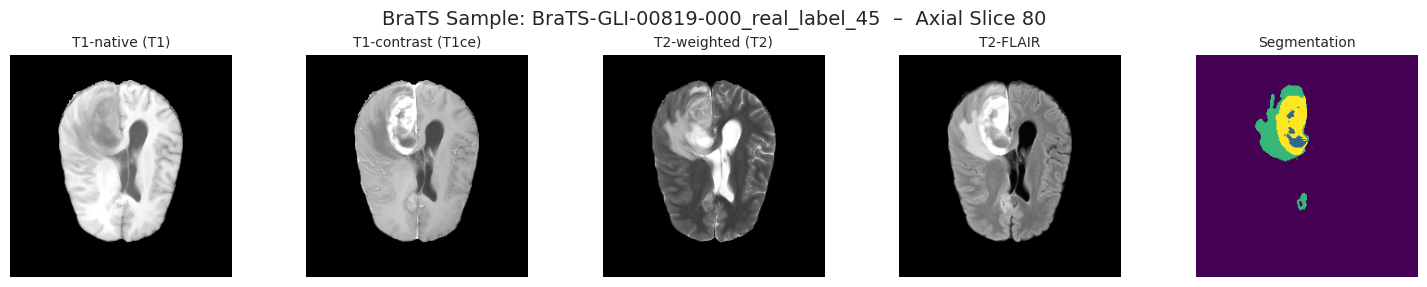

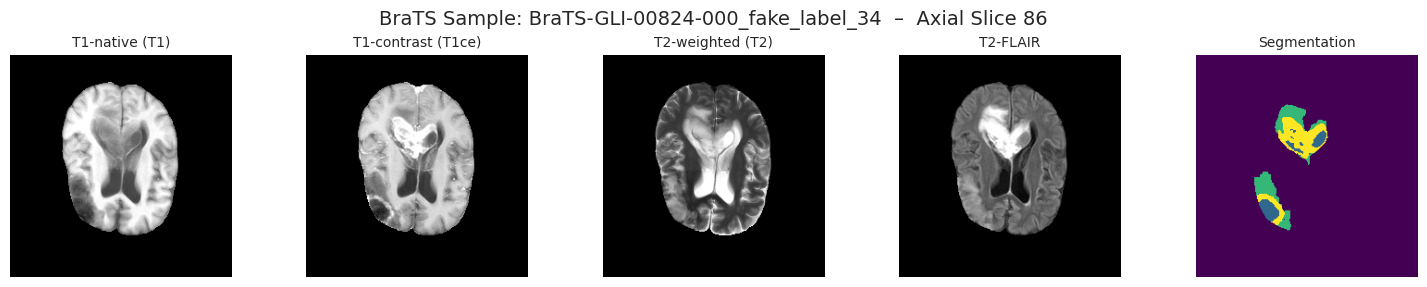

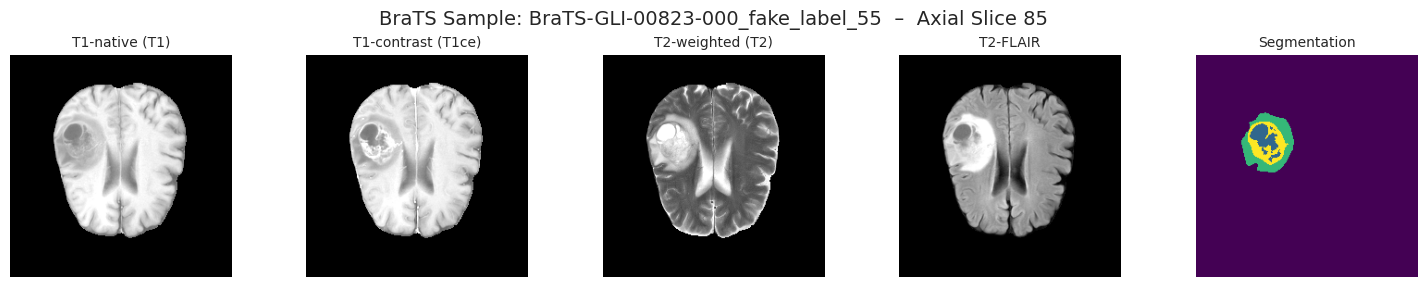

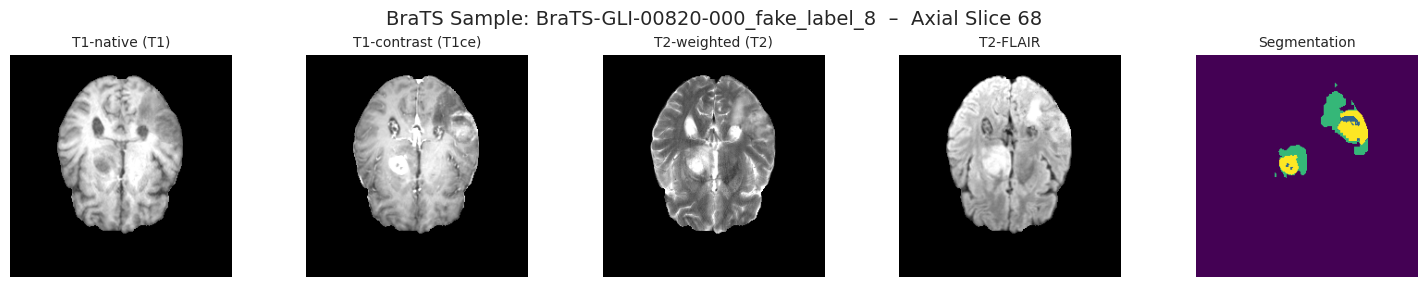

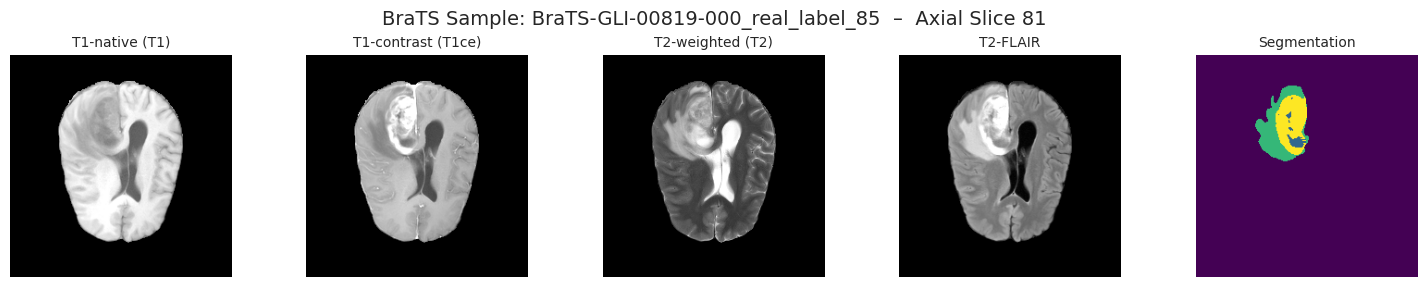

In [13]:
import random, numpy as np, nibabel as nib, matplotlib.pyplot as plt
from pathlib import Path

# 目录与文件名模板 -------------------------------------------------------------
BASE = Path("/content/drive/MyDrive/data/gan_data/Synthetic_dataset_random_labels")
MODS = {"t1":"T1-native (T1)",
        "t1ce":"T1-contrast (T1ce)",
        "t2":"T2-weighted (T2)",
        "flair":"T2-FLAIR"}
SEG_SUFFIX = "-seg.nii.gz"

def load_case(case: Path):
    """返回四模态 3-D 数组 (dict) 与标签数组"""
    imgs = {m: nib.load(case/f"{case.name}-scan_{m}.nii.gz").get_fdata() for m in MODS}
    seg  = nib.load(case/f"{case.name}{SEG_SUFFIX}").get_fdata()
    return imgs, seg.astype(int)

def find_best_slice(seg):
    """找肿瘤体素最多的轴向切片索引"""
    counts = seg.sum(axis=(0,1))      # z 方向逐 slice 计数
    return counts.argmax()

def normalize(img):
    vmin, vmax = np.percentile(img, (1, 99))
    return np.clip((img-vmin)/(vmax-vmin), 0, 1)

def show_random_examples(n=10, rng_seed=None):
    random.seed(rng_seed)
    cases = random.sample([d for d in BASE.iterdir() if d.is_dir()], n)

    for idx, case in enumerate(cases, 1):
        imgs, seg = load_case(case)
        z = find_best_slice(seg)
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(f"BraTS Sample: {case.name}  –  Axial Slice {z}", fontsize=14, y=0.95)

        for ax, (m, title) in zip(axes, MODS.items()):
            ax.imshow(normalize(imgs[m][:,:,z].T), cmap="gray", origin="lower")
            ax.set_title(title, fontsize=10); ax.axis("off")

        axes[-1].imshow(seg[:,:,z].T, cmap="viridis", origin="lower")
        axes[-1].set_title("Segmentation", fontsize=10); axes[-1].axis("off")

        plt.tight_layout(); plt.show()

# 运行：显示 10 个随机病例
show_random_examples(n=10, rng_seed=42)